## Question 2: ADQL

**Summary:** *A colleague is interested in the open cluster Ruprecht 147 (RA = 289.074 deg, Dec =-16.323 deg) and is considering an observation proposal using the 2dF fibre positioner and HERMES spectrograph (effective for Gaia G band magnitudes < 14). They need to know if there are enough bright stars in this region for observation, and how bright these stars would be in the wavelength region of the APOGEE spectrograph (which operates in the H-band). Your task is to assist by querying data from Gaia DR3 and performing some basic analysis.*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [3]:
# Step 1: Download all stars within 1 degree of Ruprecht 147 with G < 14 and 2MASS crossmatch
query = """
SELECT gaia.source_id, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.parallax, 
tmass.j_m, tmass.ks_m, tmass.h_m, tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON
   xjoin.original_psc_source_id = tmass.designation
WHERE 
gaia.phot_g_mean_mag < 14 AND
CONTAINS(
        POINT('ICRS', gaia.ra, gaia.dec),
        CIRCLE('ICRS', 289.074, -16.323, 1.0)
      ) = 1;
"""

# Since we downloaded directly from the Gaia archive (as opposed to using astroquery), we load the data:
data = Table.read('../data/gaia-tmass-query.csv', format='csv')
data = data.to_pandas()
display(data.head())
print("Table length:", len(data))

,source_id,phot_g_mean_mag,bp_rp,parallax,j_m,ks_m,h_m,ph_qual
0,4088892600474423808,11.983528,1.559996,0.624552,10.017,9.218,9.410,AAA
1,4088893154546972672,12.048648,1.703223,0.454480,9.941,9.005,9.188,AAA
2,4088893188906716032,12.808913,1.847858,0.211160,10.526,9.503,9.733,AAA
3,4087815667506086656,12.800300,1.850592,0.092825,10.501,9.492,9.710,AAA
4,4087815697559746304,11.617373,3.226758,0.366892,8.277,7.032,7.314,AAA


Table length: 3637


The number of stars returned from this query is 3637.

In [4]:
# Step 2: Identify stars with bad photometry or negative parallax
ph_mask = (data['ph_qual'] != 'AAA')
par_mask = (data['parallax'] < 0)
quality_data = data[~(ph_mask | par_mask)]
print("Number of stars with good photometry and positive parallax:", len(quality_data))

Number of stars with good photometry and positive parallax: 3553


The number of stars remaining after cutting the bad photometry and negative parallaxes is 3553.

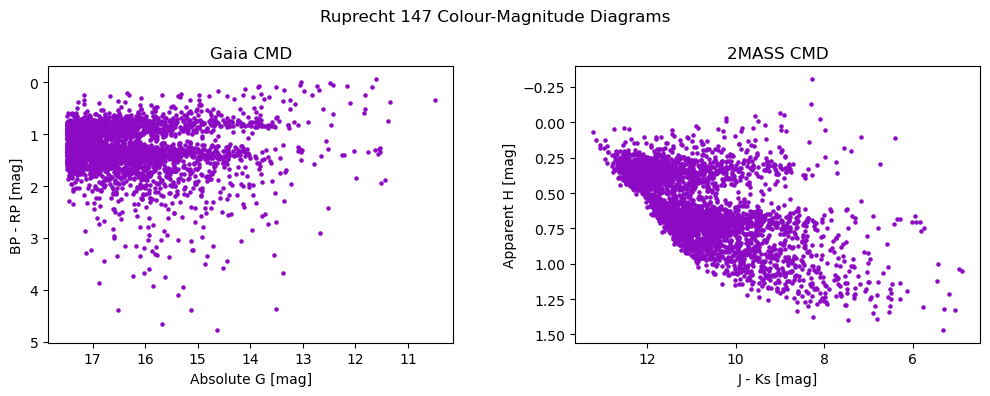

In [12]:
# Step 3: Generate figure with remaining stars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Left panel: BP-RP vs. abs G
abs_g = quality_data['phot_g_mean_mag'] + 5*np.log10(quality_data['parallax']/1000 + 5)
ax1.scatter(abs_g, quality_data['bp_rp'], s=5, color="#8C0AC3")
ax1.set_ylabel('BP - RP [mag]')
ax1.set_xlabel('Absolute G [mag]')
ax1.set_title('Gaia CMD')
ax1.invert_xaxis()
ax1.invert_yaxis()
# Right panel: J-Ks vs. app H
ax2.scatter(quality_data['h_m'], quality_data['j_m'] - quality_data['ks_m'], s=5, color="#8C0AC3")
ax2.set_ylabel('Apparent H [mag]')
ax2.set_xlabel('J - Ks [mag]')
ax2.set_title('2MASS CMD')
ax2.invert_yaxis()
ax2.invert_xaxis()
# Add an overall title to the figure
fig.suptitle('Ruprecht 147 Colour-Magnitude Diagrams')
plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.savefig('../figures/cmds_R147.png', dpi=200)
plt.show()

*Give your colleague a recommendation for the potential proposal when only judging the fibre usage, that is, how many fibres of 2dF are available and would be used.*

The 2dF fibre positioner allows the simultaneous spectral acquisition of up to 392 objects within a $2^{\circ}$ field of view. Our sample of potential objects which follows the outlined guides results in 3553 potential targets, 9 times greater than the numebr of available fibres, meaning that my colleague would have a strong argument for the use of the spectrograph as the fibre usage of 100% is an effective and efficient use of the instrument. I would reccommend that they go through with the proposal, and argue for observing time for multiple plates of fibre positions, allowing them to characterise the individual stars in this cluster hundreds of times faster than with single-slit spectroscopy. 